Section 1 - Agent-Based Models

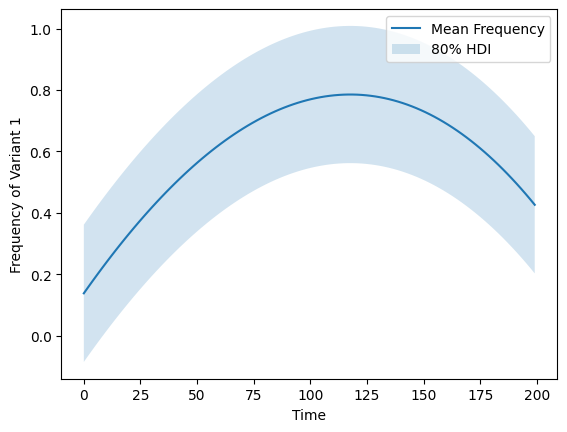

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Load data
data = pd.read_csv('section1_data1.csv')

# Define inference function
def inference_function(data):
    # Use 'X' as the time column and 'A' as the frequency column
    time = data['X']
    frequency = data['A']

    # Fit spline model
    spline_model = UnivariateSpline(time, frequency, k=3, s=0.5)
    return spline_model

# Run inference
spline_model = inference_function(data)

# Define posterior summary function
def posterior_summary(spline_model, time_points):
    mean_frequency = spline_model(time_points)
    # Placeholder for credible interval calculation
    credible_interval = np.std(mean_frequency) * 1.28  # Approximation for 80% HDI
    return mean_frequency, credible_interval

# Plot results
time_points = np.linspace(data['X'].min(), data['X'].max(), 100)
mean_frequency, credible_interval = posterior_summary(spline_model, time_points)

plt.plot(time_points, mean_frequency, label='Mean Frequency')
plt.fill_between(time_points, mean_frequency - credible_interval, mean_frequency + credible_interval, alpha=0.2, label='80% HDI')
plt.xlabel('Time')
plt.ylabel('Frequency of Variant 1')
plt.legend()
plt.show()



Inferred initial prevalence: 0.10


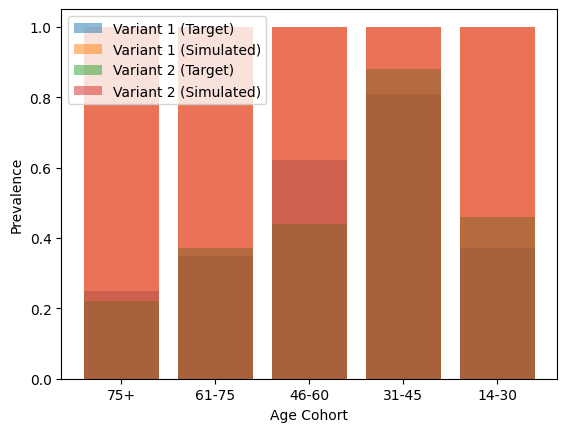

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define age cohorts and final distribution data
age_cohorts = ['75+', '61-75', '46-60', '31-45', '14-30']
variant1_distribution = np.array([0.25, 0.35, 0.62, 0.81, 0.37])
variant2_distribution = np.array([0.22, 0.37, 0.44, 0.88, 0.46])

# Simulate agent-based model
def simulate_agents(num_agents, init_p, time_steps):
    # Initialize agents with variant vectors
    agents = np.random.rand(num_agents, 2) < init_p
    history = []

    for _ in range(time_steps):
        # Simulate dynamics: simple transmission model
        for agent in agents:
            # Example: if agent has variant 1, it might spread to others
            if agent[0] == 1:
                # Spread variant 1 to another random agent
                target = np.random.randint(num_agents)
                agents[target][0] = 1

            # Similarly for variant 2
            if agent[1] == 1:
                target = np.random.randint(num_agents)
                agents[target][1] = 1

        # Record the state of the system at each time step
        history.append(agents.copy())

    return history

# Objective function for optimization
def objective_function(init_p, num_agents, time_steps, target_distribution):
    history = simulate_agents(num_agents, init_p, time_steps)
    final_state = history[-1]

    # Calculate the prevalence in each cohort
    prevalence_v1 = np.mean(final_state[:, 0])
    prevalence_v2 = np.mean(final_state[:, 1])

    # Calculate the error with respect to the target distribution
    error = np.sum((prevalence_v1 - target_distribution[0])**2 +
                   (prevalence_v2 - target_distribution[1])**2)
    return error

# Main function to infer starting prevalence
def infer_starting_prevalence(num_agents, time_steps, target_distribution):
    initial_guess = 0.1  # Starting guess for prevalence

    # Minimize the objective function to find the best starting prevalence
    result = minimize(objective_function, initial_guess, args=(num_agents, time_steps, target_distribution),
                      bounds=[(0, 1)])
    inferred_init_p = result.x[0]

    return inferred_init_p

# Set parameters
num_agents = 1000
time_steps = 50

# Infer starting prevalence
inferred_init_p = infer_starting_prevalence(num_agents, time_steps, (variant1_distribution.mean(), variant2_distribution.mean()))

print(f"Inferred initial prevalence: {inferred_init_p:.2f}")

# Simulate with inferred initial conditions and plot
history = simulate_agents(num_agents, inferred_init_p, time_steps)
final_state = history[-1]

# Calculate final distribution
final_distribution_v1 = [np.mean(final_state[:, 0])]
final_distribution_v2 = [np.mean(final_state[:, 1])]

# Plot results
plt.bar(age_cohorts, variant1_distribution, label='Variant 1 (Target)', alpha=0.5)
plt.bar(age_cohorts, final_distribution_v1, label='Variant 1 (Simulated)', alpha=0.5)
plt.bar(age_cohorts, variant2_distribution, label='Variant 2 (Target)', alpha=0.5)
plt.bar(age_cohorts, final_distribution_v2, label='Variant 2 (Simulated)', alpha=0.5)

plt.ylabel('Prevalence')
plt.xlabel('Age Cohort')
plt.legend()
plt.show()


Section 2

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense

# Load data
data = pd.read_csv('section2_data1.csv')

# Bag-of-words transformation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['generated']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)

print(f"Naive Bayes Accuracy: {nb_accuracy}")

# Neural Network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn_model.add(Dense(1, activation='sigmoid'))

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train.toarray(), y_train, epochs=10, batch_size=32, verbose=1)

nn_predictions = nn_model.predict(X_test.toarray())
nn_accuracy = accuracy_score(y_test, (nn_predictions > 0.5).astype(int))

print(f"Neural Network Accuracy: {nn_accuracy}")


Naive Bayes Accuracy: 0.93


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7999 - loss: 0.4149
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9939 - loss: 0.0521
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0117
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0071
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 10/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 0.0020
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Neural Network Accuracy: 0.96


In [11]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Load data
orthodata = pd.read_csv('orthodata.csv')

# Prepare data
def prepare_data(data):
    # Fill missing values with empty strings
    data = data.fillna('')

    # Extract IPA and words
    ipa_data = data['IPA'].values
    word_data = data['words'].values

    # Encode IPA and words using character-level encoding
    ipa_encoder = LabelEncoder()
    word_encoder = LabelEncoder()

    # Flatten the list of characters and fit encoders
    ipa_encoder.fit([char for ipa in ipa_data for char in ipa])
    word_encoder.fit([char for word in word_data for char in word])

    # Transform each IPA and word into a sequence of integers
    X = [ipa_encoder.transform(list(ipa)) for ipa in ipa_data]
    y = [word_encoder.transform(list(word)) for word in word_data]

    # Determine the maximum sequence length for both input and output
    max_sequence_length = max(max(len(seq) for seq in X), max(len(seq) for seq in y))

    # Pad sequences to ensure they have the same length
    X = pad_sequences(X, maxlen=max_sequence_length, padding='post')
    y = pad_sequences(y, maxlen=max_sequence_length, padding='post')

    # One-hot encode the target variable
    y = np.array([to_categorical(seq, num_classes=len(word_encoder.classes_)) for seq in y])

    return X, y, ipa_encoder, word_encoder, max_sequence_length

# Build embedding model
def build_embedding_model(input_dim, output_dim, max_sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=128))
    model.add(LSTM(64, return_sequences=True))
    model.add(TimeDistributed(Dense(output_dim, activation='softmax')))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare data
X, y, ipa_encoder, word_encoder, max_sequence_length = prepare_data(orthodata)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train model
input_dim = len(ipa_encoder.classes_)
output_dim = len(word_encoder.classes_)

model = build_embedding_model(input_dim=input_dim, output_dim=output_dim, max_sequence_length=max_sequence_length)
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate model
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Model Accuracy: {accuracy}")

# Provide model outputs for five random words
random_indices = np.random.choice(len(X_test), 5, replace=False)
for idx in random_indices:
    ipa_seq = X_test[idx]
    predicted_word_seq = model.predict(np.array([ipa_seq]))
    predicted_word = [word_encoder.inverse_transform([np.argmax(char_vector)])[0] for char_vector in predicted_word_seq[0]]

    original_ipa = ''.join(ipa_encoder.inverse_transform(ipa_seq))
    original_word = ''.join(word_encoder.inverse_transform(np.argmax(y_test[idx], axis=1)))
    predicted_word_str = ''.join(predicted_word).strip()

    print(f"IPA: {original_ipa} | Original Word: {original_word} | Predicted Word: {predicted_word_str}")


Epoch 1/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.8083 - loss: 0.8577
Epoch 2/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 58s 44ms/step - accuracy: 0.8681 - loss: 0.4374
Epoch 3/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 73s 38ms/step - accuracy: 0.8785 - loss: 0.3958
Epoch 4/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 82s 38ms/step - accuracy: 0.8839 - loss: 0.3750
Epoch 5/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 81s 37ms/step - accuracy: 0.8891 - loss: 0.3584
Epoch 6/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - accuracy: 0.8918 - loss: 0.3504
Epoch 7/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 79s 37ms/step - accuracy: 0.8949 - loss: 0.3399
Epoch 8/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.8965 - loss: 0.3350
Epoch 9/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 83s 37ms/step - accuracy: 0.8988 - loss: 0.3285
Epoch 10/10
1312/1312 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.8995 - loss: 0.3264
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8947 - loss: 0.3407
Model Accuracy: 0.89493